# CPU time analysis

## Setup

In [1]:
import re
import datetime
from math import log
import csv
import pprint
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

%matplotlib inline

pp = pprint.PrettyPrinter()

## Open connection to ES

In [2]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

## List all jobs\_archive\_* indices

In [3]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
#print indices

## Function to list all jobs\_archive\_* indices in the last N days

In [4]:
def time_filter(indices, last_days=1):
    if last_days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

## Group by (processingtype, transformation) and plot distribution of average CPU time/event by jeditaskid

In [7]:
ind = time_filter(indices, 0)
ind = ','.join(ind)
s = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "must": [
                        {
                            "range": {
                                "nevents": {"gte": 1}
                            }
                        },
                        {
                            "match": {
                                "jobstatus": "finished"
                            }
                        }
                    ],
                    "must_not": [
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "panda*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "pmerge*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "merge*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "hammercloud*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "gangarobot*"
                                }
                            }
                        },
                        {
                            "query": {
                                "wildcard": {
                                    "processingtype": "*jedi*"
                                }
                            }
                        }                        
                    ]
                }
            }
        }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 1000
            },
            "aggs": {
                "transf": {
                    "terms": {
                        "field": "transformation",
                        "size": 1000
                    },
                    "aggs": {
                        "jtask": {
                            "terms": {
                                "field": "jeditaskid",
                                "size": 1000000
                            },
                            "aggs": {
                                "1": {
                                    "extended_stats": {
                                        "script": "(doc['nevents'].value) ? doc['cpuconsumptiontime'].value/doc['nevents'].value : 0",
                                        "lang": "expression"
                                    }
                                },
                                "2": {
                                    "extended_stats": {
                                        "script": "(doc['nevents'].value) ? doc['wall_time'].value/doc['nevents'].value : 0",
                                        "lang": "expression"
                                    }
                                },
                                "3": {
                                    "sum": {
                                        "field": "cpuconsumptiontime"
                                    }
                                },
                                "4": {
                                    "sum": {
                                        "field": "wall_time"
                                    }
                                },
                                "5": {
                                    "sum": {
                                        "script": "(doc['corecount'].value) ? doc['cpuconsumptiontime'].value/doc['corecount'].value : 0",
                                        "lang": "expression"
                                    }
                                },
                                "6": {
                                    "avg": {
                                        "field": "corecount"
                                    }
                                },
                                "7": {
                                    "sum": {
                                        "field": "nevents"
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=12000)

In [8]:
with open('tasks.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['transf']['buckets']
        for b2 in buckets2:
            transf = b2['key']
            buckets3 = b2['jtask']['buckets']
            for b3 in buckets3:
                writer.writerow([
                    b3['key'],
                    ptype,
                    transf,
                    b3['1']['count'],
                    b3['1']['avg'],
                    b3['1']['std_deviation'],
                    b3['2']['avg'],
                    b3['2']['std_deviation'],
                    b3['3']['value'],
                    b3['4']['value'],
                    b3['5']['value'],
                    b3['6']['value'],
                    b3['7']['value']
                        ])

## Import to a DataFrame

In [9]:
df = pd.read_csv('tasks.csv', dtype={'cpu_n': 'float'}, names=['jeditaskid', 'processingtype', 'transformation', 'njobs',
                                                               'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg', 'wallevt_rms',
                                                               'cpu', 'wc', 'cpu_n', 'cores', 'jevts'])

In [10]:
df.ix[0:2]

,jeditaskid,processingtype,transformation,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cpu_n,cores,jevts
0,4837745,simul,Sim_tf.py,200000,267.172163,107.276692,67.079476,30.252072,5343443260,1341589524,6.679304e+08,8,20000000
1,6573834,simul,Sim_tf.py,138961,342.697628,184.181129,436.172761,527.524193,1190540127,1515275077,1.190540e+09,1,3474025
2,6384045,simul,Sim_tf.py,114772,38.787529,7.159354,7.005103,1.684035,890344457,160797942,1.112931e+08,8,22954400


The following is the list of (processingtype, transformation) combinations with some statistics.

In [11]:
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)
a = grouped.agg({'jeditaskid': 'count',
                 'cpuevt_avg' : 'mean',
                 'wallevt_avg': 'std',
                 'wc': 'sum',
                 'njobs': 'sum',
                 'jevts': 'sum'})
a.sort_values('wc', ascending=False)


,processingtype,transformation,wc,cpuevt_avg,jevts,wallevt_avg,njobs,jeditaskid
5,evgen,Generate_tf.py,8.117690e+11,275.220579,12820456953,1882.837126,22271597,16289
31,simul,Sim_tf.py,4.888131e+11,360.173719,6784894396,1505.859354,22265598,18109
27,simul,AtlasG4_tf.py,2.331257e+11,51.258596,1570247775,934.063867,10383045,33398
10,pile,Reco_tf.py,1.556276e+11,63.479538,11359682478,65.962578,10227998,29131
6,evgen,Generate_trf.py,9.417730e+10,8.459723,3129526169,39.003940,2256567,34154
7,pile,DigiMReco_trf.py,9.015305e+10,65.286082,1284258043,144.093788,3107406,18711
24,reprocessing,Reco_tf.py,3.086216e+10,49.807630,16100943370,274.949064,7224058,4714
28,simul,AtlasG4_trf.py,2.929446e+10,240.614018,267788577,330.089041,884002,270
12,recon,DigiMReco_trf.py,2.760436e+10,57.488516,421358265,88.832416,939832,15113
14,recon,Reco_tf.py,1.306391e+10,59.891596,1836395059,278.739230,2516815,4615


## Jobs per task

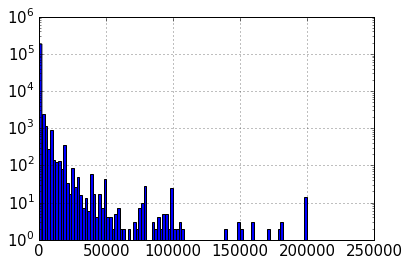

In [12]:
plt.rcParams.update({'font.size': 15})
fig = df['njobs'].hist(bins=100, log=True)

## Events per task

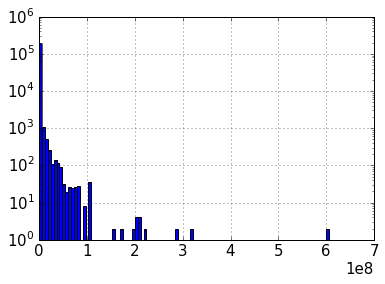

In [13]:
fig = df['jevts'].hist(bins=100, log=True)

## Plot distribution of averages of CPU time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average CPU time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average CPU time per event.
Combinations consisting of merge jobs, of that use less than 1.5% of the total wall-clock time, are ignored.

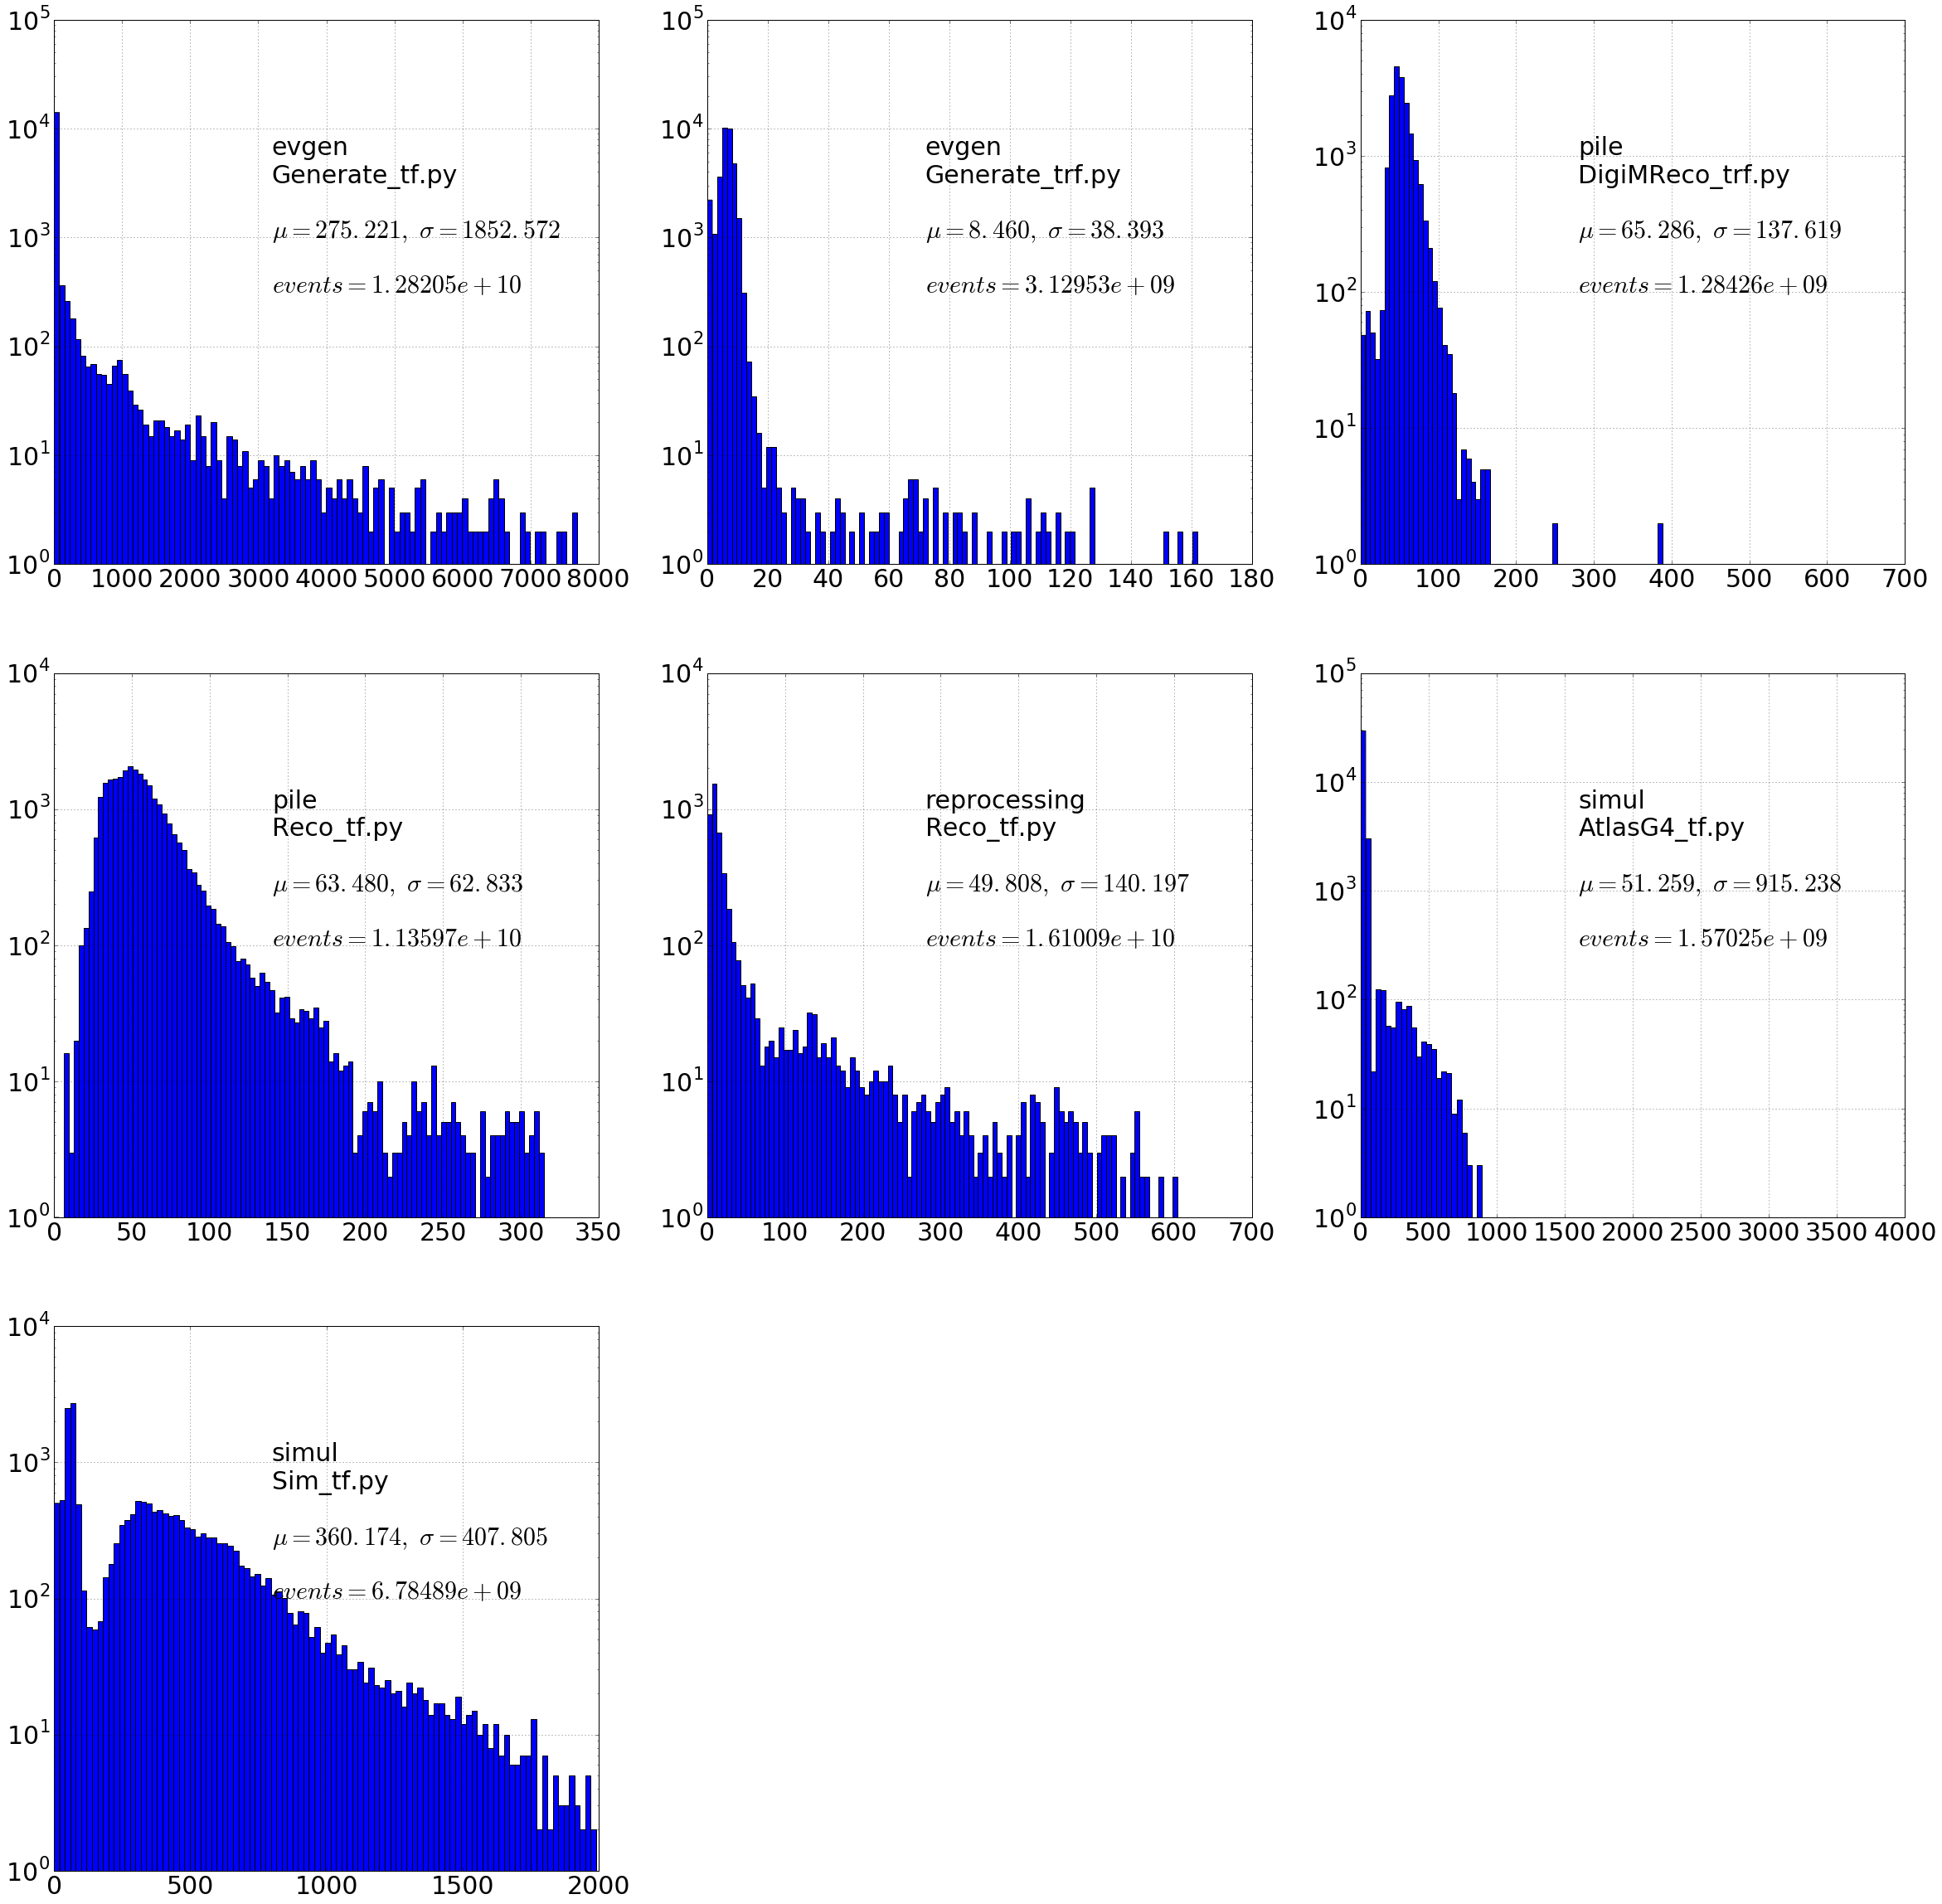

In [27]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = g[var].mean()
    std = g[var].std()
    range = [0., mean + std * 4]
    sp = plt.subplot(3, 3, i)
    g[var].hist(bins=100, range=range, log=True)
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(1.)**.7, p+'\n'+t)
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), t_y(1.)**.6, stats)
    stats = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), t_y(1.)**.5, stats)
    i += 1

## Plot distribution of averages of wallclock time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average wallclock time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average wallclock time per event.

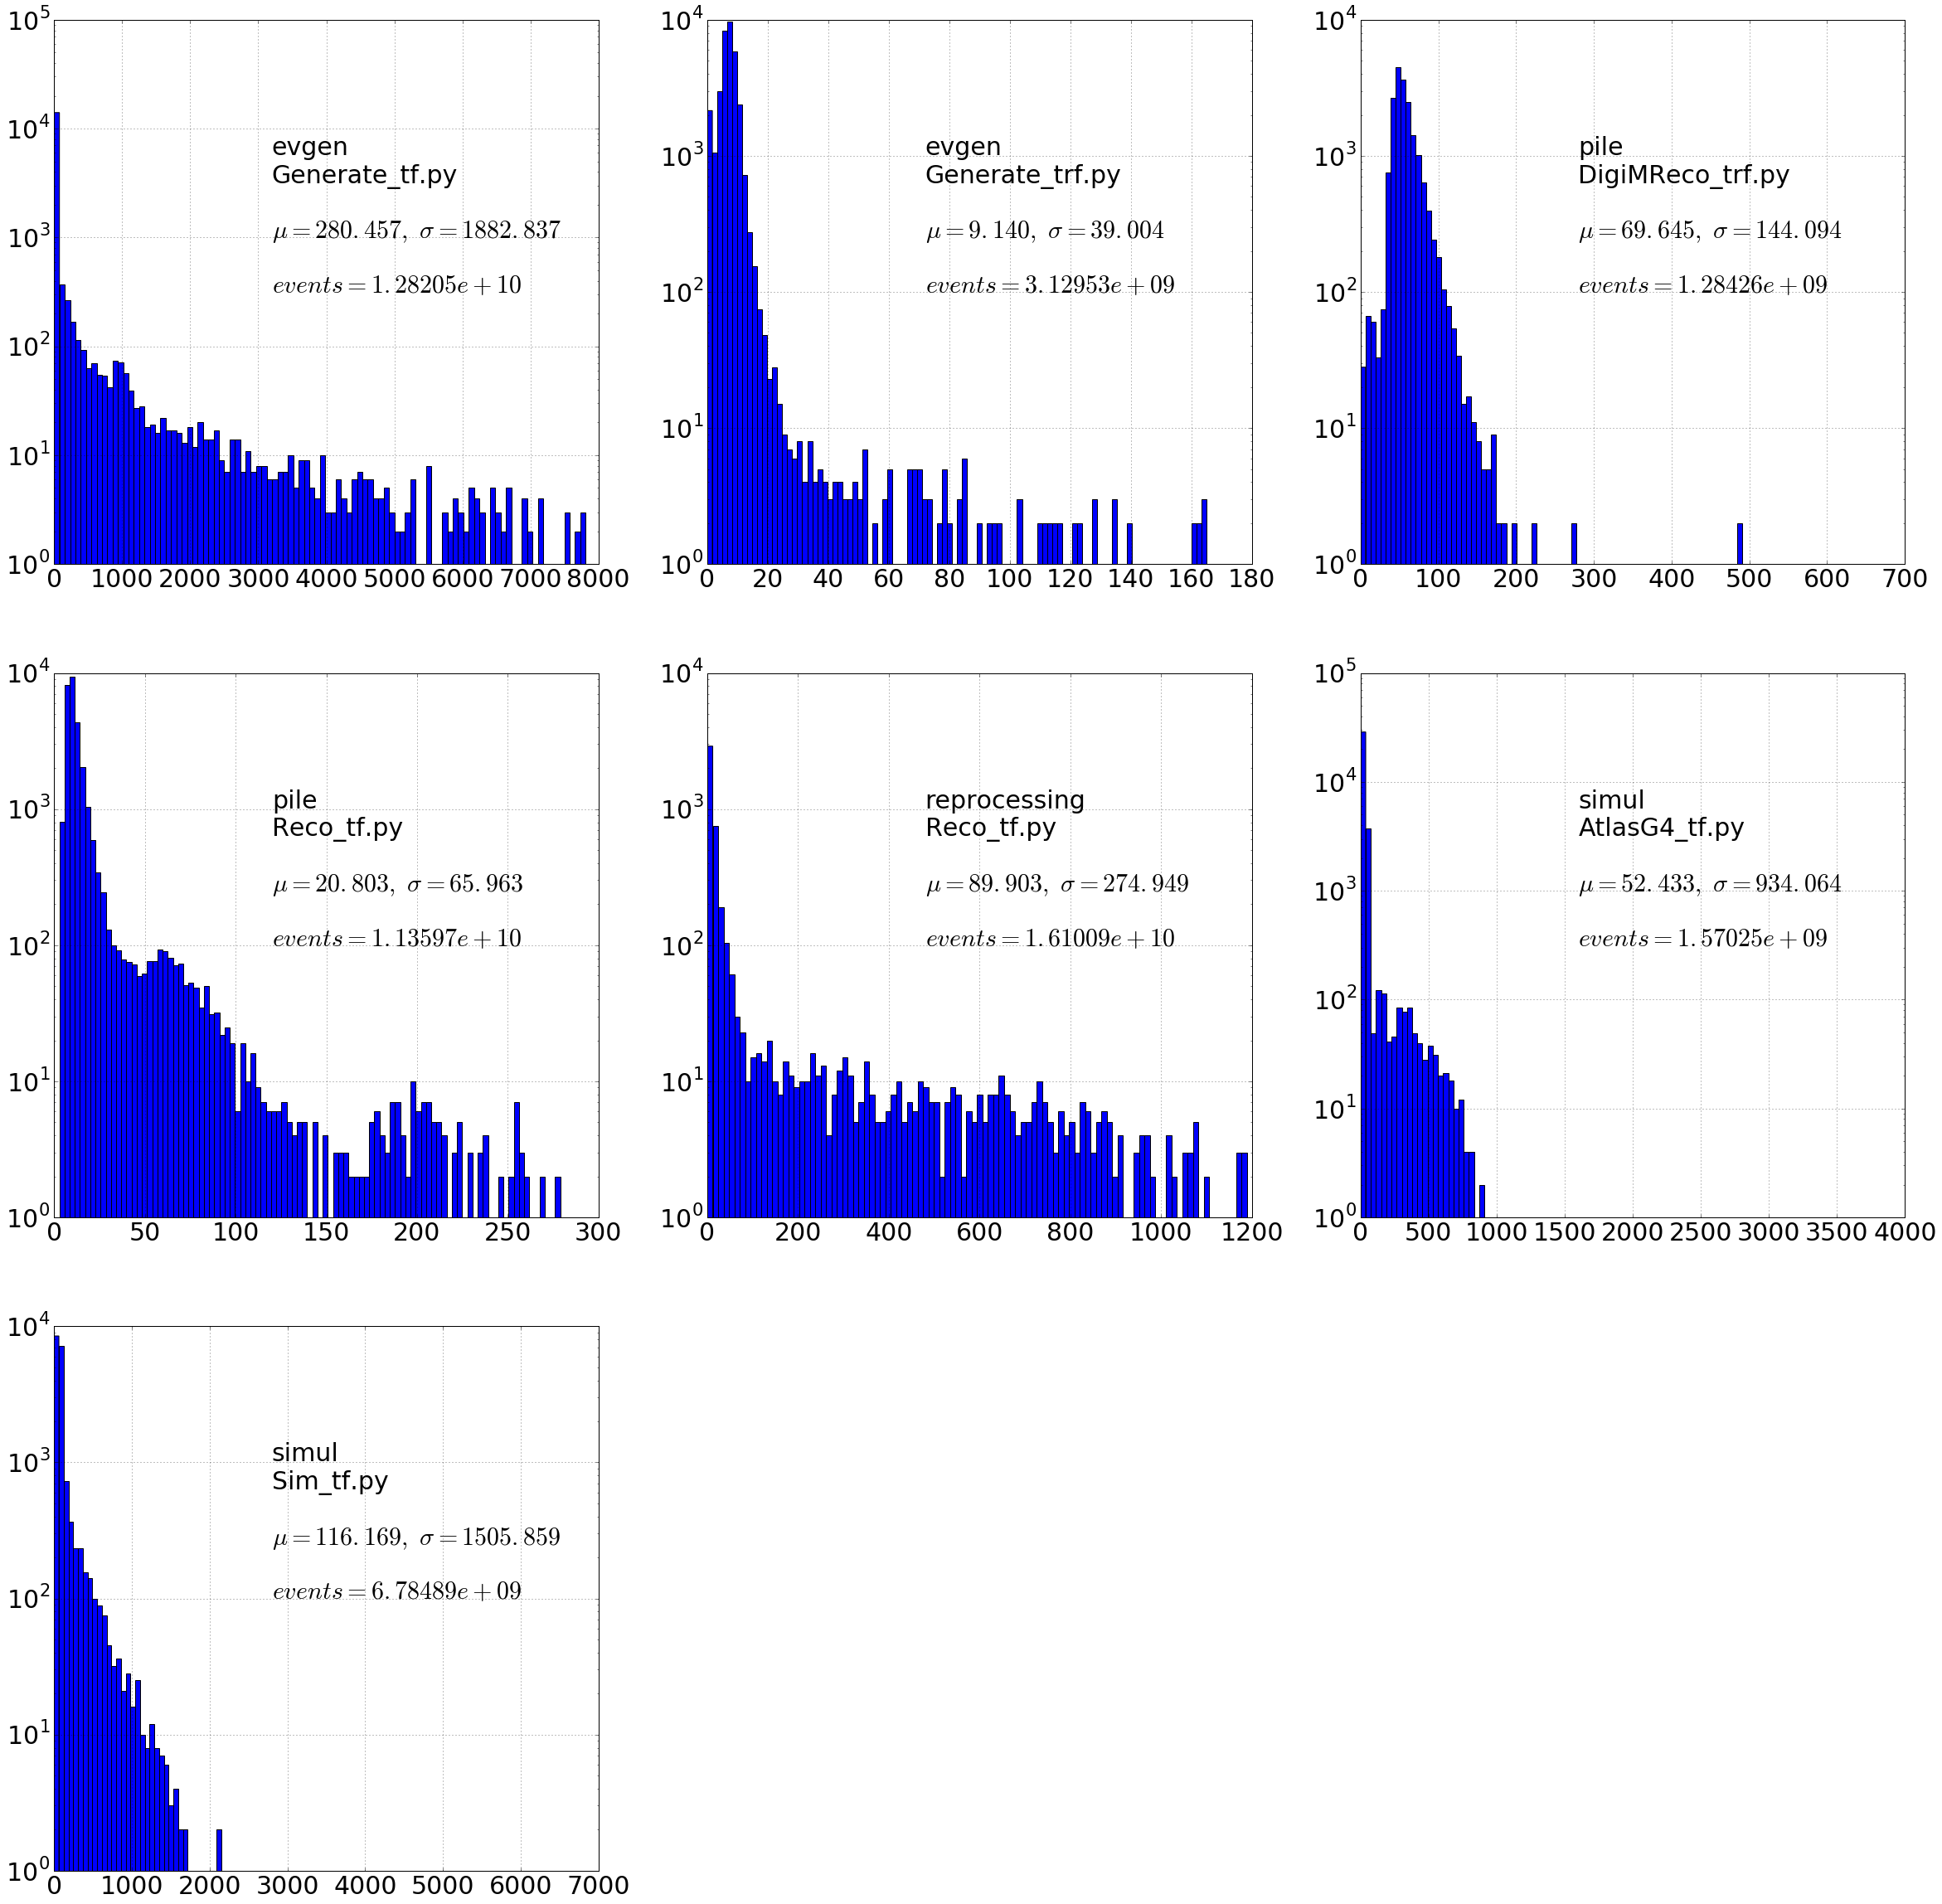

In [28]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = g[var].mean()
    std = g[var].std()
    range = [0., mean + std * 4]
    sp = plt.subplot(3, 3, i)
    g[var].hist(bins=100, range=range, log=True)
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(1.)**.7, p+'\n'+t)
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), t_y(1.)**.6, stats)
    stats = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), t_y(1.)**.5, stats)
    i += 1